# Think Bayes

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite

import thinkbayes2
import thinkplot

import numpy as np
from scipy.special import gamma

### World Cup problem, part two

> In the final match of the 2014 FIFA World Cup, Germany defeated Argentina 1-0.  How much evidence does this victory provide that Germany had the better team?  What is the probability that Germany would win a rematch?

Scoring in games like soccer and hockey can be modeled by a Poisson process, which assumes that each team, against a given opponent, will score goals at some goal-scoring rate, $\lambda$, and that this rate does not vary; in other words, the probability of scoring a goal is about the same at any point during the game.

Based on this modeling decision, we can answer the questions by

1. Defining a prior distribution for each team's goal-scoring rate against the other,
2. Updating the prior based on the outcome of the game,
3. Using the posterior distributions to compute the probability that Germany's goal-scoring rate is higher.
4. Generating a predictive distribution for the number of goals each team would score in a rematch.

I'll start with Step 2.

### Step 2: Updating

If goal-scoring is a Poisson process, the distribution of goals per game is Poisson with parameter $\lambda$.  To compute the distribution of $\lambda$ we can define a new class that inherits from `thinkbayes2.Suite` and provides an appropriate `Likelihood` function:

In [2]:
class Soccer2(thinkbayes2.Suite):
    """Represents hypotheses about goal-scoring rates."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: goal rate in goals per game
        data: goals scored in a game
        """
        # FILL THIS IN!
        return 1

In [3]:
# Solution

from scipy.stats import poisson

class Soccer2(thinkbayes2.Suite):
    """Represents hypotheses about goal-scoring rates."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: goal rate in goals per game
        data: goals scored in a game
        """
        return poisson.pmf(data, hypo) 

`Likelihood` computes the likelihood of `data` given `hypo`, where `data` is an observed number of goals, and `hypo` is a hypothetical goal-scoring rate in goals per game.  We can compute the likelihood of the data by evaluating the Poisson probability mass function (PMF).

Now we can get back to Step 1.

### Step 1: Constructing the prior

Before the game starts, what should we believe about each team's goal scoring rate against each other?  We could use previous tournament results to construct the priors, but to keep things simple, I'll just use the average goal-scoring rate from all matches in the tournament, which was 2.67 goals per game (total for both teams).

To construct the prior, I use a gamma distribution with a mean of 1.34 goals per game.

1.310359949002256

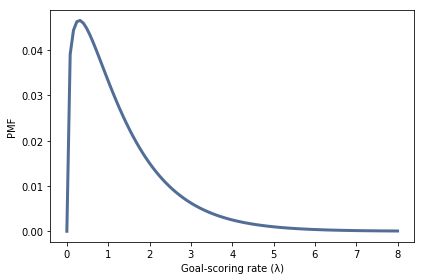

In [4]:
from thinkbayes2 import MakeGammaPmf

xs = np.linspace(0, 8, 101)
pmf = MakeGammaPmf(xs, 1.3)
thinkplot.Pdf(pmf)
thinkplot.decorate(xlabel='Goal-scoring rate (λ)',
                   ylabel='PMF')
pmf.Mean()

In [5]:
suite = Soccer2(pmf);

1.310359949002256

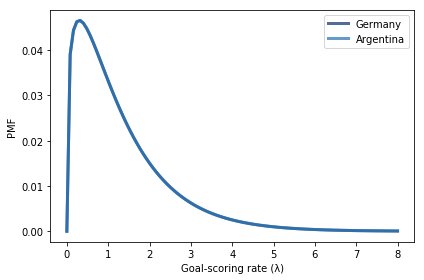

In [6]:
germany = suite.Copy(label='Germany')
argentina = suite.Copy(label='Argentina')
thinkplot.Pdf(germany)
thinkplot.Pdf(argentina)
thinkplot.decorate(xlabel='Goal-scoring rate (λ)',
                   ylabel='PMF')
pmf.Mean()

According to this prior, the goal-scoring rates are always greater than zero, with the most likely value (a priori) near 0.5.  Goal scoring rates greater than 5 are considered unlikely.

### Step 3: Comparing posteriors

The next step is to compute the posteriors for the two teams:

In [7]:
germany = suite.Copy(label='Germany')
argentina = suite.Copy(label='Argentina')
germany.Update(1)
argentina.Update(0)

print('posterior mean Germany', germany.Mean())
print('posterior mean Argentina', argentina.Mean())

posterior mean Germany 1.1506263832709267
posterior mean Argentina 0.6693817986970533


`Update` invokes the likelihood function for each hypothetical value of $\lambda$ and updates the distribution accordingly.

Since both teams scored fewer goals than the prior mean (1.4), we expect both posterior means to be lower.  

Here are the posteriors:

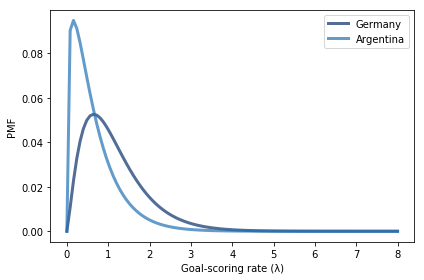

In [8]:
thinkplot.Pdf(germany)
thinkplot.Pdf(argentina)
thinkplot.decorate(xlabel='Goal-scoring rate (λ)',
                   ylabel='PMF')

To answer the first question, "How much evidence does this victory provide that Germany had the better team?", we can compute the posterior probability that Germany had a higher goal-scoring rate:

In [9]:
post_prob = germany.ProbGreater(argentina)
print('posterior prob Germany > Argentina', post_prob)

posterior prob Germany > Argentina 0.6983938606019376


Based on the prior distributions, we would have said that Germany had a 50% chance of having the better team, or 1:1 odds.  Based on the posteriors, we would say that Germany has a 70% chance.  We can use the ratio of the prior and posterior odds to compute the Bayes factor, which measures the strength of the evidence.

In [10]:
prior_odds = 1
post_odds = post_prob / (1 - post_prob)
print('posterior odds Germany > Argentina', post_odds)   
k = post_odds / prior_odds
print('Bayes factor', k)   

posterior odds Germany > Argentina 2.315582375066283
Bayes factor 2.315582375066283


The Bayes factor is about 2.3, which is generally considered weak evidence.

Now on to Step 4.

### Step 4: Comparing posterior distributions

**Exercise:**  Write a few lines of code to 

1. Choose a random value of `lam` from the posterior distribution of each team.

2. Choose a random number of goals for each team, conditioned on the value of `lam` you chose.

3. Run that "simulation" many times and accumulate the distribution of wins, losses, and ties.

Use the results to estimate the probability that Germany would win a rematch.

In [11]:
# Solution

gdr_goals = poisson.rvs(germany.Sample(1000))
arg_goals = poisson.rvs(argentina.Sample(1000))
np.mean(gdr_goals > arg_goals)

0.418

In [12]:
# Solution

np.mean(gdr_goals == arg_goals)

0.329

In [13]:
# Solution

np.mean(gdr_goals < arg_goals)

0.253

Instead of running simulations, you could compute the posterior predictive distributions explicitly.

Write a function called `PredictiveDist` that takes the posterior distribution of $\lambda$ and a duration (in units of games).

It should loop through the hypotheses in `suite`, compute the predictive distribution of goals for each hypothesis, and assemble a "meta-Pmf" which is a Pmf that maps from each predictive distribution to its probability.

Finally, it should use `MakeMixture` to compute the mixture of the predictive distributions.

In [14]:
# Solution

def PredictiveDist(suite, duration=1, label='pred'):
    """Computes the distribution of goals scored in a game.

    returns: new Pmf (mixture of Poissons)
    """
    metapmf = thinkbayes2.Pmf()
    for lam, prob in suite.Items():
        pred = thinkbayes2.MakePoissonPmf(lam * duration, 10)
        metapmf[pred] = prob

    mix = thinkbayes2.MakeMixture(metapmf, label=label)
    return mix

In [15]:
germany_pred = PredictiveDist(germany, label='germany')
argentina_pred = PredictiveDist(argentina, label='argentina');

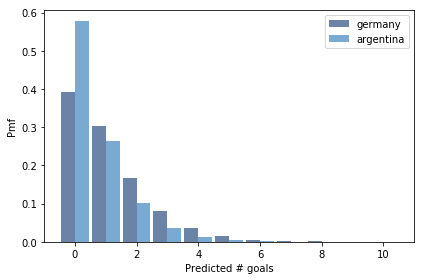

In [16]:
thinkplot.Hist(germany_pred, width=0.45, align='right')
thinkplot.Hist(argentina_pred, width=0.45, align='left')
thinkplot.decorate(xlabel='Predicted # goals',
                   ylabel='Pmf')

Using the predictive distributions, we can compute probabilities for the outcomes of a rematch.

In [17]:
win = germany_pred.ProbGreater(argentina_pred)
lose = germany_pred.ProbLess(argentina_pred)
tie = 1 - (win + lose)

print('Posterior prob Germany wins rematch', win)
print('Posterior prob tie', tie)
print('Posterior prob Argentina wins rematch', lose)

Posterior prob Germany wins rematch 0.44773969920578044
Posterior prob tie 0.3270825241713642
Posterior prob Argentina wins rematch 0.2251777766228554
